### Napari tests

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os , sys
sys.path.append('..')
from pathlib import Path
cur_path = Path(os.getcwd()).parent

from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style='white')
%config InlineBackend.figure_format = 'retina'

In [3]:
import napari

In [4]:
viewer = napari.Viewer()

2025-01-23 15:44:38.009 python[14063:8084564] +[IMKClient subclass]: chose IMKClient_Modern
2025-01-23 15:44:38.009 python[14063:8084564] +[IMKInputSession subclass]: chose IMKInputSession_Modern


#### Initiate the SAM2 model like you do in Napari

In [5]:
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch
from octron.sam2_octron.helpers.build_sam_octron import build_sam2_video_predictor_octron

In [6]:
sam2_folder = Path('sam2_octron')
checkpoint = 'sam2.1_hiera_large.pt' # under folder /checkpoints
model_cfg = 'sam2.1/sam2.1_hiera_l.yaml' # under folder /configs
# ------------------------------------------------------------------------------------
sam2_checkpoint = cur_path / sam2_folder / Path(f'checkpoints/{checkpoint}')
model_cfg = Path(f'configs/{model_cfg}')


predictor, device  = build_sam2_video_predictor_octron(config_file=model_cfg.as_posix(), 
                                                       ckpt_path=sam2_checkpoint.as_posix(), 
                                     )


Support for MPS devices is preliminary. SAM 2 is trained with CUDA and might give numerically different outputs and sometimes degraded performance on MPS. See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion.
Uing device: mps


Loaded SAM2VideoPredictor OCTRON
Model image size: 1024


### From napari, after loading video file, extract info 

In [7]:
# ... first load video into napari 

In [8]:
viewer.dims.set_point(0,10)
current_indices = viewer.dims.current_step
print(current_indices)

(10, 971, 971)


In [9]:
video_data = viewer.layers[0].data   # the whole video

num_frames = video_data.shape[0]
frame_height = video_data[0].shape[0]
frame_width = video_data[0].shape[1]
print(f'video shape: {video_data.shape}')   

video shape: (1603, 1944, 1944, 3)


In [10]:
def get_mean_std(video_data, num_frames, max_num_frames=50):
    '''
    Given a large video data set, 
    calculate the mean and std of a subset 
    of all frames 
    ''' 
    num_frames = video_data.shape[0]
    which_frames = np.linspace(0, num_frames-1, np.min([num_frames, max_num_frames])).astype(int)
    accumulated_frames = np.stack([video_data[i] for i in which_frames])
    mean = np.mean(accumulated_frames,axis=None)
    std =  np.std(accumulated_frames,axis=None)
    return mean, std

In [11]:
img_mean, img_std = get_mean_std(video_data, num_frames, max_num_frames=100)
print(f'Mean: {img_mean:.1f}, Std: {img_std:.1f}')   

Mean: 44.8, Std: 42.8


In [12]:
# We want to get tdeo inference state initialization 

Text(0.5, 1.0, 'First frame')

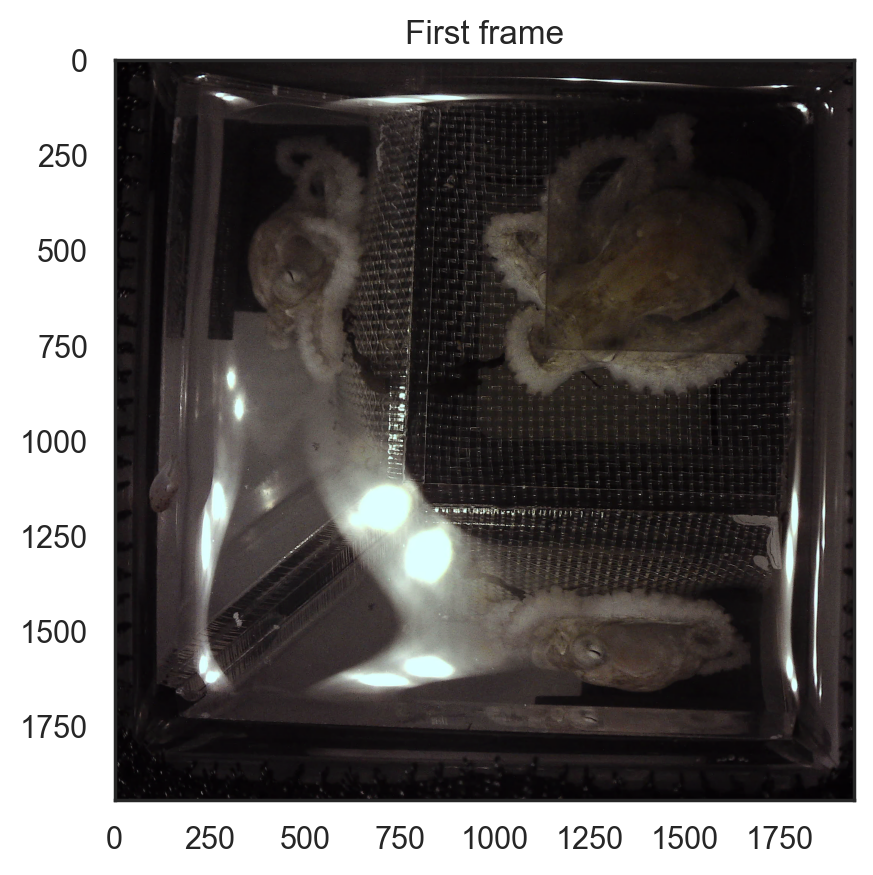

In [13]:
img_np = video_data[:20] # Get the first 30 frames
plt.imshow(img_np[0])
plt.title('First frame')

In [14]:
img_np.shape

(20, 1944, 1944, 3)

In [15]:
from torchvision.transforms import Resize

images = [torch.from_numpy(img).permute(2, 0, 1) for img in img_np]
images = torch.stack(images, dim=0).float() / 255.0

img_mean=(0.485, 0.456, 0.406)
img_std=(0.229, 0.224, 0.225)
img_mean = torch.tensor(img_mean, dtype=torch.float32)[:, None, None]
img_std = torch.tensor(img_std, dtype=torch.float32)[:, None, None]
print(img_mean.shape, img_std.shape )  

resize = Resize(
    size=(predictor.image_size)
)
images = resize(images)
print(images.shape)


# # #  # normalize by mean and std
images -= img_mean
images /= img_std

images = images.to(device)
img_mean = img_mean.to(device)
img_std = img_std.to(device)


torch.Size([3, 1, 1]) torch.Size([3, 1, 1])
torch.Size([20, 3, 1024, 1024])


In [16]:
inference_state = predictor.init_state(images=images)

/Users/horst/miniconda3/envs/sam2/lib/python3.10/site-packages/torch/nn/functional.py:4594: UserWarning: The operator 'aten::upsample_bicubic2d.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch._C._nn.upsample_bicubic2d(


Initialized SAM2 model


In [17]:
# viewer.dims.set_point(0,10)
# current_indices = viewer.dims.current_step
# print(current_indices)
# image_data1 = viewer.layers[0].data[current_indices[0],:,:,:]
# image_data1.shape
# plt.imshow(image_data1)
# plt.show() 
# # Set to different index 
# viewer.dims.set_point(0,11)
# current_indices = viewer.dims.current_step
# print(current_indices)
# current_indices = viewer.dims.current_step
# image_data2 = viewer.layers[0].data[current_indices[0],:,:,:]
# image_data2.shape
# plt.imshow(image_data2)


In [18]:
predictor.reset_state(inference_state)

In [19]:
from sam2_octron.helpers.visualization import show_points, show_mask

In [20]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)
# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[700,200]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
# Predict 
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 2  # give a unique id to each object we interact with (it can be any integers)
# Let's add a positive click at (x, y) = (210, 350) to get started
points2 = np.array([[250,300]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
# Predict 
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points2,
    labels=labels,
    
)

ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 3  # give a unique id to each object we interact with (it can be any integers)
# Let's add a positive click at (x, y) = (210, 350) to get started
points3 = np.array([[690,800],[680,720]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1,0], np.int32)
# Predict 
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points3,
    labels=labels,
    
)


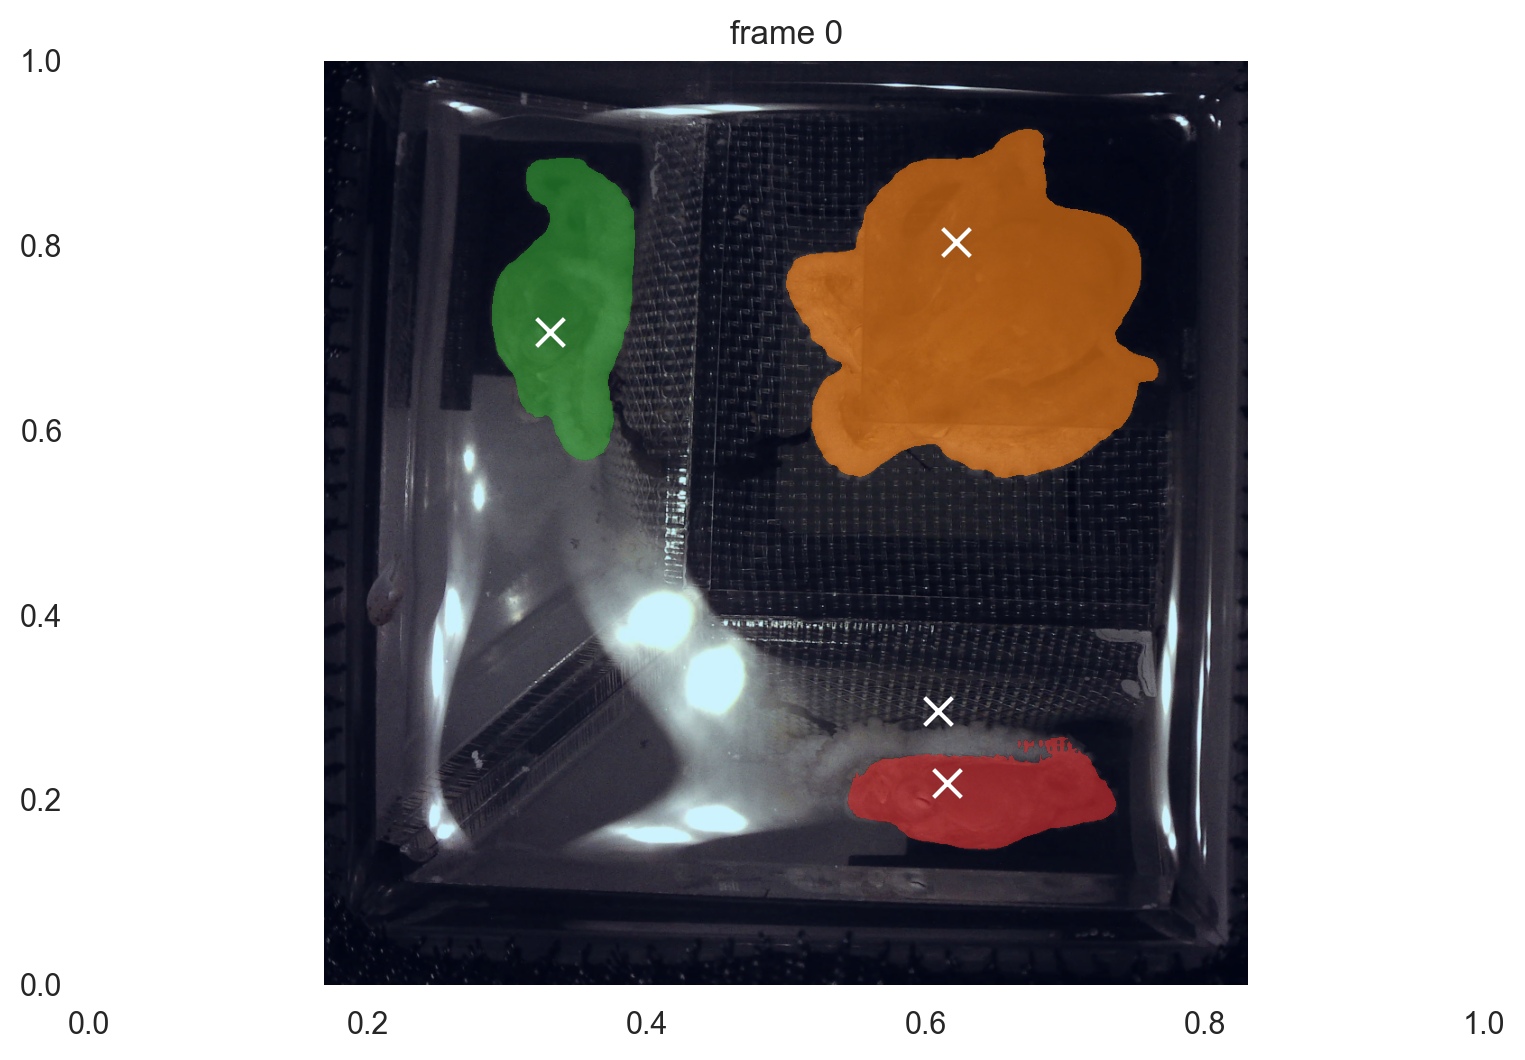

In [21]:
# show the results on the current (interacted) frame
figure = plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
ax = figure.add_subplot(111)
ax.set_yticks([]); ax.set_xticks([])    
img = inference_state['images'][ann_frame_idx].to('cpu').detach().numpy()
img = np.moveaxis(img, 0, -1)
img += np.abs(img.min())
img /= img.max()    
ax.imshow(img)

for obj in range(out_mask_logits.shape[0]):
    show_mask((out_mask_logits[obj] > 0.0).cpu().numpy(), ax, obj_id=out_obj_ids[obj])

for p in points: # show the clicked points
    ax.scatter(p[0], p[1], marker='x',s=100, color='white')
for p in points2: # show the clicked points
    ax.scatter(p[0], p[1], marker='x',s=100, color='white')
for p in points3: # show the clicked points
    ax.scatter(p[0], p[1], marker='x',s=100, color='white')
sns.despine(left=True,bottom=True)